In [1]:
from app import app, db
from app.models import User, Review, Business, Category
import numpy as np
import pandas as pd
import itertools as it
import networkx as nx

from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from bokeh.charts import Histogram
from bokeh.charts import defaults, vplot, hplot, show, output_file
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
from bokeh.io import output_notebook
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment
from bokeh.palettes import Viridis6 as palette
palette.reverse()
%matplotlib inline

/Users/mayen/anaconda/envs/python35/lib/python3.5/site-packages/flask_sqlalchemy/__init__.py:800: UserWarning: SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True to suppress this warning.
  warnings.warn('SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True to suppress this warning.')


Creating DB


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
business = pd.read_sql_table('business',app.config['SQLALCHEMY_DATABASE_URI'])
category = pd.read_sql_table('category',app.config['SQLALCHEMY_DATABASE_URI'])

In [4]:
reviews = pd.read_sql_table('reviews',app.config['SQLALCHEMY_DATABASE_URI'])

In [5]:
def pair_links(id1,id2,business=business,reviews=reviews):
    name1 = business[business['business_id']==id1]['name'].values[0]
    name2 = business[business['business_id']==id2]['name'].values[0]
    r1 = reviews[reviews['business_id'] == id1]
    r2 = reviews[reviews['business_id'] == id2]
    users1 = set(r1['user_id'])
    users2 = set(r2['user_id'])
    common = len(users1&users2)
    return common

In [6]:
pizza = business.merge(category[category['category']=='Pizza'],how='inner',on='business_id')
pizza.head()

,id_x,business_id,full_address,open,city,state,name,stars,review_count,lon,lat,price_range,type,id_y,category
0,23,6o3RK6rTcN3nw-j-r2nQmA,"231 E Main St\nCarnegie\nCarnegie, PA 15106",True,Carnegie,PA,Porto Fino Pizzaria & Gyro,2.5,4,-80.084934,40.408832,NaN,business,64,Pizza
1,34,t_gan0EXAw8csKIeFyazJw,"820 Amity St\nHomestead\nHomestead, PA 15120",True,Homestead,PA,Homestead Capri Pizza,2.0,4,-79.910527,40.406705,1.0,business,97,Pizza
2,51,-taSf0shFSUKy9iCXnySsA,"2615 Main St\nHomestead, PA 15120",True,Homestead,PA,Italian Village Pizza,2.5,6,-79.900010,40.392552,NaN,business,156,Pizza
3,63,6p9TlP2I8S4agxYMNFSDjg,205 East Waterfront Drive\nHomestead\nHomestea...,True,Homestead,PA,Uno Pizzeria & Grill,3.0,55,-79.914136,40.410967,2.0,business,191,Pizza
4,74,uLnDFdn011hEroQQMLmxNQ,"3502 Main St\nMunhall, PA 15120",True,Munhall,PA,The Pizza Company,4.0,12,-79.903300,40.385718,1.0,business,226,Pizza


In [43]:
businesses = pizza[pizza['state']=='PA']
pairs = partial(pair_links,business=businesses)
business_pairs = it.combinations(businesses['business_id'].values,2)

In [44]:
p = Pool(6)
common = p.starmap(pair_links,business_pairs)

In [45]:
G = nx.Graph()
G.add_nodes_from(businesses['name'].values)
business_pairs = it.combinations(businesses['business_id'].values,2)
for pair,weight in zip(business_pairs,common):
    if weight == 0: continue
    id1,id2 = pair
    name1 = business[business['business_id']==id1]['name'].values[0]
    name2 = business[business['business_id']==id2]['name'].values[0]
    G.add_edge(name1,name2, weight=weight)

In [46]:
sub = businesses
m = Basemap(
        projection='merc',
        llcrnrlon=sub['lon'].min()-0.1*sub['lon'].min(),
        llcrnrlat=sub['lat'].min()-0.1*sub['lat'].min(),
        urcrnrlon=sub['lon'].max()+0.1*sub['lon'].max(),
        urcrnrlat=sub['lat'].max()+0.1*sub['lat'].max(),
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

In [47]:
pos = {}
size = []
for i,row in businesses.iterrows():
    name = row['name']
    lat,lon = row['lat'],row['lon']
    mx,my = m(lon,lat)
    pos[name] = (mx,my)
    size.append(row['review_count'])
size = np.array(size)

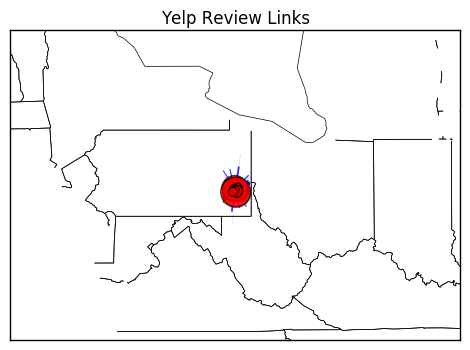

In [48]:
#draw nodes
nodes = nx.draw_networkx_nodes(G,pos,node_size=size+10,alpha=0.7,color='b')
#edges
weights = list(map(lambda x: x[2]['weight'],G.edges(data=True)))
edges = nx.draw_networkx_edges(G,pos,alpha=0.8,width=weights,edge_color='b')

m.drawcountries()
m.drawstates()

plt.title('Yelp Review Links')
plt.show()

In [49]:
states = {key:val for key,val in states.items() if key not in ['AK','HI']}
state_xs = [state["lons"] for state in states.values()]
state_ys = [state["lats"] for state in states.values()]

state_names = [state for state,val in states.items()]
color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names
))

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(
    title="Texas Unemployment, 2009", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_alpha=0.7, line_color="white", line_width=0.5)

p.scatter(x=pizza['lon'].values, y=pizza['lat'].values,
         fill_color='red')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("(Long, Lat)", "($x, $y)"),
]

show(p)

ValueError: Out of range float values are not JSON compliant

In [59]:
states = db.session.query(Business.city).filter_by(state=None).distinct()

In [ ]:
states.all()

[]